## Shannon Moran <br>
Phys 514 <br>
HW 6<br>
Due: Oct 26

## Import required packages

In [1]:
%matplotlib inline
import numpy as np
from math import *
import matplotlib.pyplot as plt
import time
import random

## Initialize Ising lattice

Set the initial configuration to a randon lattice.

In [2]:
def init_lattice(L,p):
    random_lattice = np.random.random((L,L))
    lattice = (random_lattice<=p)*1
    np.place(lattice,lattice==0,-1)
    return lattice

## Simulate the Ising model using Monte Carlo

Simulate the Ising model,

$$ H = -J\sum_{\langle i,j \rangle}S_iS_j$$

on a square lattice in two dimensions using Metropolis Monte Carlo with single spin flip updates.

### Monte Carlo helper calculations

In [ ]:
# Calculate nn spin interactions, taking PBC into account
def nn_spin(spins):
    # Divide by two to avoid double-counting spins
    neighbors = np.copy(spins*(np.roll(spins,+1,axis=1)+np.roll(spins,+1,axis=0)
                               +np.roll(spins,-1,axis=1)+np.roll(spins,-1,axis=0))/2)
    return neighbors


# Calculate binder cumulant
def binder_cumulant(M):
    M4 = np.average(np.power(M,4))
    M2 = np.average(np.power(M,2))**2
    return 1-M4/(3*M2)

### Monte Carlo method execution

In [28]:
# Execute single spin flip
def spin_flip(configuration):
    positions = np.arange(configuration.shape[0])
    flip_i = random.choice(positions)
    flip_j = random.choice(positions)
    flipped = np.copy(configuration)
    flipped[flip_i][flip_j] *= -1
    return flipped


# Execute single MC step
def MC_step(config_old,J,beta,status='run'):
    global moves
    config_new = np.copy(spin_flip(config_old))
    E_old = -J*np.sum(nn_spin(config_old))
    E_new = -J*np.sum(nn_spin(config_new))
    E_del = E_new - E_old
    if E_del<0: config = np.copy(config_new); E=E_new
    else:
        p = np.exp(-beta*E_del)
        r = random.random()
        if r<p: config = np.copy(config_new); E=E_new; moves+=1
        else: config = np.copy(config_old); E=E_old
    M = (np.sum(config)/config.shape[0]**2)**2
    if status=="init": return config
    else: return config,E,M 
    

# Execute MC_simulation for specified number of steps
def MC_simulate(lattice,N_run,J,beta):
    global moves
    E = []
    M = []
    L = lattice.shape[0]
    step = 0
    moves = 0
    while step<N_run:
        step+=1
        lattice,Ei,Mi = np.copy(MC_step(lattice,J,beta))
        E.append(Ei)
        M.append(Mi)
    # Calculate properties
    T = 1/beta
    properties = {
        'E': E,
        'M': M,
        'S': (np.mean(np.power(M,2)/L**2)-(np.average(np.abs(M))**2/(L**2)))/T,
        'C': (np.mean(np.power(E,2))-np.mean(E)**2)/T**2,
        'U': binder_cumulant(M),
    }
    return lattice,properties

Something is not working-- can use this site for reference to troubleshoot:
https://github.com/prtkm/ising-monte-carlo/blob/master/ising-monte-carlo.org

Good site for checking the physics: http://quantumtheory.physik.unibas.ch/people/bruder/Semesterprojekte2007/p1/

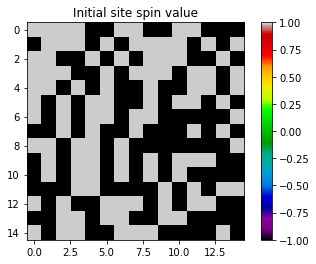

In [21]:
# Set initialization parameters
p = 0.5
L = int(15)

lattice0 = np.copy(init_lattice(L,p))
plt.imshow(lattice0,cmap='nipy_spectral',interpolation="none")
plt.title('Initial site spin value')
plt.colorbar()
plt.show()

In [ ]:
# Add a quick demonstration that this works

## Compute system properties versus T

Compute the expectation values of the absolute value of the magnetization, magnetic susceptibility, the energy, and the specific heat as a function of temperature.

The expectation value of a quantity $A$ at a finite temperature $T$ is given by a sum over all states in the simulation:
$$ \langle A \rangle = \frac{1}{Z}\sum_i A_i exp(\beta E_i) $$

where $\beta=1/kT$, $A_i$ is the value of the quantity $A$ in the configuration $i$ with energy $E_i$.

The partition function is given by:
$$ Z = \sum_i exp(-\beta E_i) $$

This normalizes the probabilities $p_i=exp(\beta E_i)/Z$.

0.20060385468
Move acceptance @ T=0.5: 0.01232
0.49150726911
Move acceptance @ T=2.27: 0.14018
-3.09951888404
Move acceptance @ T=5.0: 0.5141


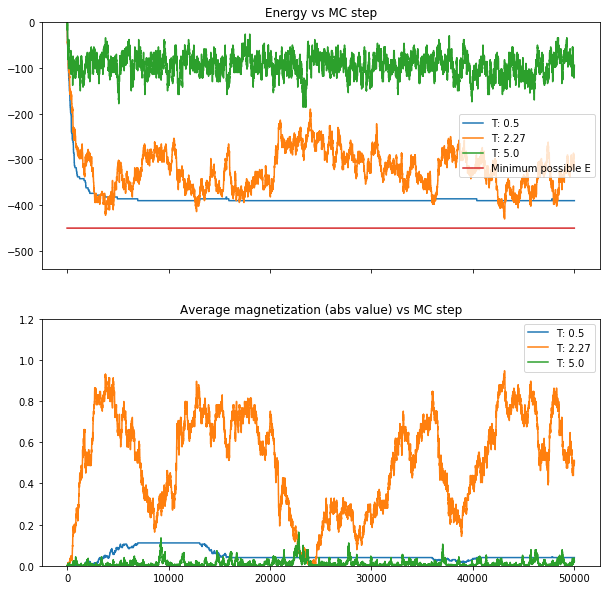

In [26]:
lattice = np.copy(lattice0)

# Set simulation parameters
moves = 0
N_init = 0
N_run = int(5e4)
MC_steps = np.arange(N_run)

# T is in units J/kB
J = 1
T_range = np.asarray([0.5, 2.27, 5.0])

# Run MC simulations over range of temperatures
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(10,10))
for T in T_range:
    _,props = np.copy(MC_simulate(lattice,N_run,J,1/T))
    ax1.plot(MC_steps,props['E'],label='T: %s' %T)
    ax2.plot(MC_steps,props['M'],label='T: %s' %T)
    print('Move acceptance @ T=%s: %s'%(T,moves/N_run))
    
# Consolidate plots of results.
E_min = int(-L**2*2*J)
ax1.plot(MC_steps,E_min*np.ones(N_run),label='Minimum possible E')
ax1.set_title('Energy vs MC step')
ax1.set_ylim([E_min*1.2, 0])
ax1.legend(loc=0)
ax2.set_title('Average magnetization (abs value) vs MC step')
ax2.set_ylim([0, 1.2])
ax2.legend(loc=0)
plt.show()

## Find phase transition locations

Find the approximate location of the phase transition on small lattices.

We'll use the Binder cumulant method for this and look for where the values cross-- this should give us the approximate $T_C$.

Notes:
- We can start with a pretty small system. (Gull cited 8 in class.)
- I should add in replicates here to get better statistics

In [ ]:
L_range = np.linspace(10,30,3,dtype=np.int16)
T_range = np.linspace(1.5,4,10,dtype=np.int16)
reps = 3
for L in L_range:
    lattice = np.copy(init_lattice(L,p))
    U = []
    U_reps = np.zeros((reps,N_run))
    for rep in range(reps):
        for T in T_range:
            _,properties = np.copy(MC_simulate(lattice,N_run,J,1/T))
            U.append(properties['U'])
        U_reps[rep][:] = U
    U_avg = np.average(U_reps,axis=0)
    plt.plot(T_range,U_avg,label='L=%s'%L)
    
plt.legend()
plt.show()